<a href="https://colab.research.google.com/github/DamianDominoDavis/sommalier/blob/master/sommalier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#V.1 Exploring the green reds
As a beginner in machine learning, you recall that one of the best things to do before
breaking out the machine learning tools is to explore and look at your data.

*Technically the best thing to do first would be to clean the data and
check for anomalies, errors, and outliers! But since, Marvin gave us
this data, we’ll trust him. This time...*

1. Write a function that will plot a scatterplot matrix of your red wine data. Your
function should plot wines with quality over some “good_threshold” as one color,
and wines below some “bad_threshold” as another. Your plotting function should
have the option to save a .png of your plots. Here’s an example function definition:

`def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False)`


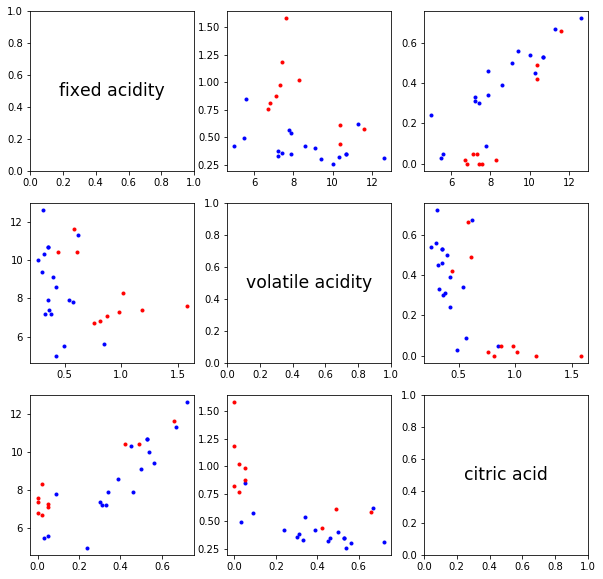

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    style_good = 'b.'
    style_bad = 'r.'
    txt_args = {'size':'xx-large', 'horizontalalignment':'center', 'verticalalignment':'center'}
    fig = plt.figure(num=1)
    ax = fig.subplots(3, 3)#, sharex='all', sharey='all')
    fig.set_size_inches(10,10)
    for row in range(0,3):
        for col in range(0,3):
            if row == col:
                ax[row,col].text(0.5, 0.5, dimens[row], txt_args)
            else:
                ax[row,col].plot(dimens[row], dimens[col], style_good, data=wine_data[wine_data.quality >= good_threshold])
                ax[row,col].plot(dimens[row], dimens[col], style_bad, data=wine_data[wine_data.quality <= bad_threshold])
    if save_plot is True:
        fig.savefig('wine_plot.png', dpi=100)



url = 'https://raw.githubusercontent.com/DamianDominoDavis/sommalier/master/winequality-red.csv'
csv = pandas.read_csv(url, sep=';')
dimens = ('fixed acidity', 'volatile acidity', 'citric acid')
plot_scatter_matrix(csv, 8, 3, False)
